In [96]:
import string
import re
import nltk
from nltk import word_tokenize, PorterStemmer, ToktokTokenizer, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lemur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lemur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## FONCTIONS ANNEXES

In [ ]:
def preprocess(text):
    # Removing HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Removing punctuation and non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z0-9]", " ",  str(text))

    # Tokenizing words
    words = word_tokenize(str(text))

    # Removing stopwords
    stop_words = set(stopwords.words("english"))
    words = [w for w in words if w.lower() not in stop_words]

    # Lemmatizing words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]

    return " ".join(words)

## ANALYSE DES DONNEES

In [97]:
pd.set_option('float_format', '{:f}'.format)

answers_df = pd.read_csv("data/Answers.csv", encoding='latin-1')
answers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            987122 non-null  int64  
 1   OwnerUserId   981755 non-null  float64
 2   CreationDate  987122 non-null  object 
 3   ParentId      987122 non-null  int64  
 4   Score         987122 non-null  int64  
 5   Body          987122 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 45.2+ MB


In [98]:
answers_df.isna().sum()

Id                 0
OwnerUserId     5367
CreationDate       0
ParentId           0
Score              0
Body               0
dtype: int64

In [99]:
answers_df.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.000000,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.000000,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.000000,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.000000,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.000000,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


In [100]:
answers_df.describe()

,Id,OwnerUserId,ParentId,Score
count,987122.000000,981755.000000,987122.000000,987122.000000
mean,21607440.957471,1589642.499920,20534960.850753,3.028437
std,11794878.874466,1649345.831621,11954864.488041,21.263246
min,497.000000,1.000000,469.000000,-38.000000
25%,11447745.500000,260303.000000,9968532.000000,0.000000
50%,22541876.500000,963465.000000,21035504.000000,1.000000
75%,32054689.000000,2433809.500000,31152330.250000,3.000000
max,40143370.000000,7044747.000000,40143190.000000,8384.000000


In [101]:
f"Le dataset contient {answers_df.shape[0]} réponses"

'Le dataset contient 987122 réponses'

In [102]:
questions_df = pd.read_csv("data/Questions.csv", encoding='latin-1')
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607282 entries, 0 to 607281
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            607282 non-null  int64  
 1   OwnerUserId   601070 non-null  float64
 2   CreationDate  607282 non-null  object 
 3   Score         607282 non-null  int64  
 4   Title         607282 non-null  object 
 5   Body          607282 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 27.8+ MB


In [103]:
questions_df.isna().sum()

Id                 0
OwnerUserId     6212
CreationDate       0
Score              0
Title              0
Body               0
dtype: int64

In [104]:
questions_df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.000000,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.000000,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.000000,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.000000,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.000000,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [105]:
questions_df.describe()

,Id,OwnerUserId,Score
count,607282.000000,601070.000000,607282.000000
mean,23719604.527590,2519594.996418,2.283137
std,11247153.677061,1910375.393429,19.285578
min,469.000000,25.000000,-44.000000
25%,14855187.250000,853934.000000,0.000000
50%,25318970.000000,2107677.000000,1.000000
75%,33588233.500000,3991164.000000,2.000000
max,40143365.000000,7044992.000000,5524.000000


In [106]:
f"Le dataset contient {questions_df.shape[0]} questions"

'Le dataset contient 607282 questions'

In [107]:
tags_df = pd.read_csv("data/Tags.csv", encoding='latin-1')
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885078 entries, 0 to 1885077
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 28.8+ MB


In [108]:
tags_df.isna().sum()

Id       0
Tag    443
dtype: int64

In [109]:
tags_df.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [110]:
tags_df.describe()

,Id
count,1885078.000000
mean,23917947.228089
std,11214914.197417
min,469.000000
25%,15187529.250000
50%,25597469.500000
75%,33728831.000000
max,40143365.000000


In [111]:
f"Le dataset contient {tags_df.shape[0]} tags"

'Le dataset contient 1885078 tags'

<AxesSubplot:>

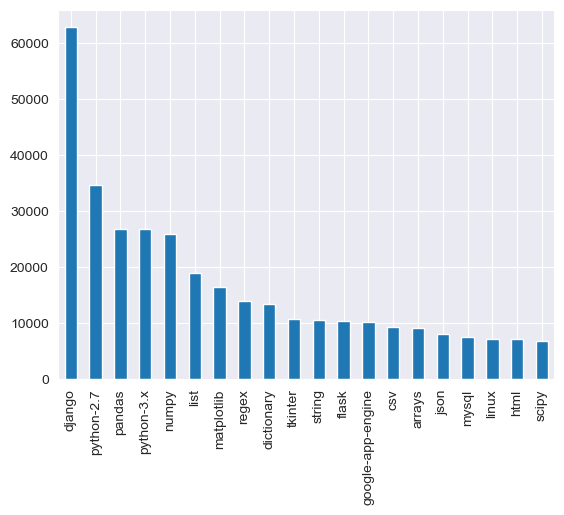

In [112]:
#most frequent tags
fig, ax = plt.subplots()
tags_df[tags_df['Tag']!='python']['Tag'].value_counts().sort_values(ascending = False)[:20].plot(ax=ax, kind='bar')

## NETTOYAGE


In [114]:
# Remove all questions that have a negative score
questions_df = questions_df[questions_df["Score"] >= 0]
questions_df

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.000000,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.000000,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.000000,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.000000,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.000000,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...
...,...,...,...,...,...,...
607277,40143190,333403.000000,2016-10-19T23:36:01Z,1,How to execute multiline python code from a ba...,<p>I need to extend a shell script (bash). As ...
607278,40143228,6662462.000000,2016-10-19T23:40:00Z,0,How to get google reCaptcha image source using...,<p>I understood that reCaptcha loads a new fra...
607279,40143267,4064680.000000,2016-10-19T23:44:07Z,0,Updating an ManyToMany field with Django rest,<p>I'm trying to set up this API so I can use ...
607280,40143338,7044980.000000,2016-10-19T23:52:27Z,2,Most possible pairs,"<p>Given a list of values, and information on ..."


In [115]:
#Concatenate Body and Title
questions_df['Text'] = questions_df["Title"]+questions_df["Body"]

In [116]:
questions_df['Text']

0         How can I find the full path to a font from it...
1         Get a preview JPEG of a PDF on Windows?<p>I ha...
2         Continuous Integration System for a Python Cod...
3         cx_Oracle: How do I iterate over a result set?...
4         Using 'in' to match an attribute of Python obj...
                                ...                        
607277    How to execute multiline python code from a ba...
607278    How to get google reCaptcha image source using...
607279    Updating an ManyToMany field with Django rest<...
607280    Most possible pairs<p>Given a list of values, ...
607281    Theano operations returning odd results<p>So I...
Name: Text, Length: 570972, dtype: object

In [117]:
questions_df['Text'].apply(lambda x:preprocess(x))

C:\Users\lemur\miniconda3\envs\MLYNOV\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


0         find full path font display name Mac using Pho...
1         Get preview JPEG PDF Windows cross platform Py...
2         Continuous Integration System Python CodebaseI...
3         cx Oracle iterate result set several way itera...
4         Using match attribute Python object arrayI rem...
                                ...                        
607277    execute multiline python code bash script need...
607278    get google reCaptcha image source using Seleni...
607279    Updating ManyToMany field Django restI trying ...
607280    possible pairsGiven list value information pos...
607281    Theano operation returning odd resultsSo tryin...
Name: Text, Length: 570972, dtype: object

In [119]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions_df["Text"])
question_sequences = tokenizer.texts_to_sequences(questions_df["Text"])

In [122]:
#Split dataset
from sklearn.model_selection import train_test_split
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(questions_df,questions_df['Text'],
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

In [ ]:
# Pad the sequences to make them the same length
max_len = max([len(s) for s in question_sequences])
question_sequences = pad_sequences(question_sequences, maxlen=max_len)

## MODEL & TRAINNING

In [ ]:
# from keras.layers import Embedding, GRU, Dense
# from keras import Sequential
#
# # Build the model
# model = Sequential()
# model.add(Embedding(len(tokenizer.word_index)+1, 100, input_length=max_len))
# model.add(GRU(100, return_sequences=True))
# model.add(GRU(100))
# model.add(Dense(1, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#
# # Fit the model on the data
# model.fit(question_sequences, answers_df["answer"], epochs=10, batch_size=32)